In [22]:
from pathlib import Path

from fibrosisanalysis.slice import HeartSliceBuilder
from fibrosisanalysis.parsers import ImageLoader, StatsLoader, DensityLoader
from fibrosisanalysis.analysis import ObjectsPropertiesBuilder, SegmentsPropertiesBuilder


# path = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/data')
path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')
path_stats = path

heart = 'E11444_LMNA'
slice_name = 'E11444_08_SC2'

# heart = 'E11444_LMNA'
# slice_name = 'E11444_10_SC2'

n_radial = 3
n_angular = 12
node_step = 3

heart_slice_builder = HeartSliceBuilder()
heart_slice_builder.build_from_file(path, 
                                    heart, 
                                    slice_name,
                                    n_angular,
                                    n_radial, 
                                    node_step)
heart_slice = heart_slice_builder.heart_slice

# Load stats
path_slice_stats = path_stats.joinpath(heart, 'Stats', slice_name)
stats_loader = StatsLoader(path_stats)
object_stats = stats_loader.load_slice_data(path_slice_stats)

# Build objects properties
objects_props_builder = ObjectsPropertiesBuilder()
objects_props_builder.build_from_stats(object_stats)
objects_props_builder.add_slice_props(heart_slice)
objects_props = objects_props_builder.objects_props

# Build segment properties
segments_props_builder = SegmentsPropertiesBuilder()
segments_props_builder.build(heart_slice, objects_props)
props = segments_props_builder.props

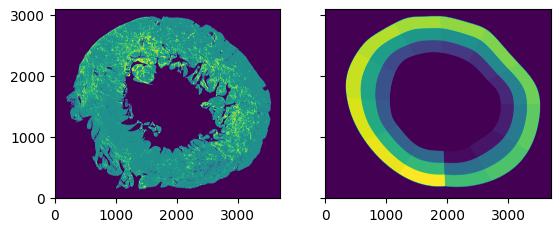

In [23]:
import matplotlib.pyplot as plt
# %matplotlib qt

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
axs[0].imshow(heart_slice.image, origin='lower')
axs[1].imshow(heart_slice.total_segments, origin='lower')
plt.show()

In [24]:
props.head()

,segment_labels,centroid-0,centroid-1,edge_direction,structural_anisotropy,sa_orientation,sa_major_axis,sa_minor_axis,fibrosis,relative_orientation
0,1,687.935772,2199.298695,1.412784,1.213079,1.608060,7.969285,6.569467,0.098857,-0.195276
1,2,894.408358,2646.419418,0.919787,1.148520,1.279463,7.543114,6.567681,0.188820,-0.359675
2,3,1288.029723,2942.700157,0.276327,1.236544,-2.773401,7.616546,6.159542,0.356184,-0.091864
3,4,1764.156837,2904.934187,-0.490824,1.472356,0.785905,8.422438,5.720380,0.220269,-1.276729
4,5,2158.384523,2576.058763,-0.787936,1.449256,-2.944932,8.023849,5.536530,0.278513,-0.984596


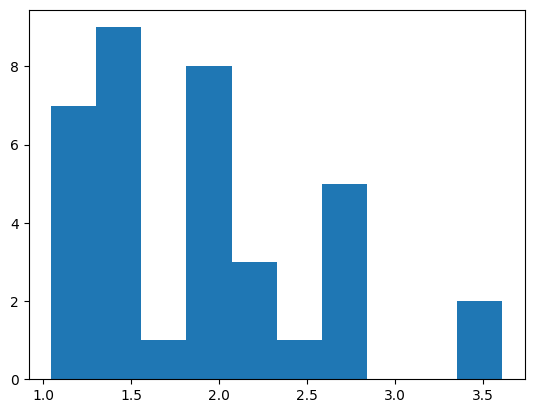

In [25]:
plt.hist(props['structural_anisotropy'].values)
plt.show()

In [26]:
props[['segment_labels', 'structural_anisotropy']]

,segment_labels,structural_anisotropy
0,1,1.213079
1,2,1.148520
2,3,1.236544
3,4,1.472356
4,5,1.449256
5,6,1.273480
6,7,1.046601
7,8,1.453391
8,9,2.779162
9,10,2.210389


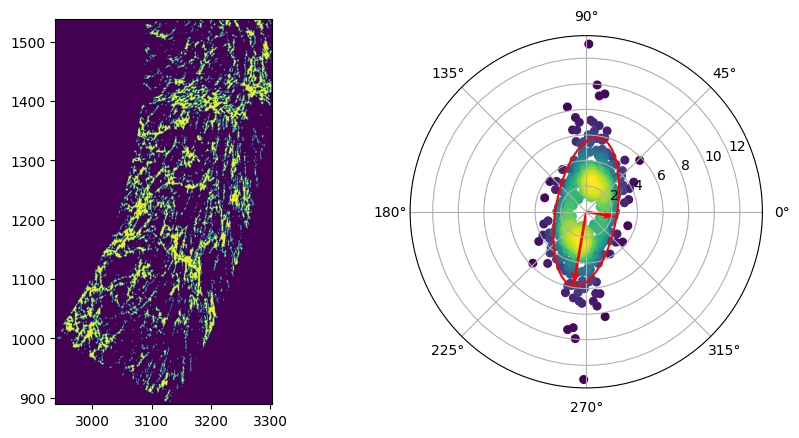

In [28]:
import numpy as np
from skimage import morphology
from bitis.texture.properties import (
    PatternPropertiesBuilder,
    PolarPlots,
    DistributionEllipseBuilder
)

def swap_axis(angle):
    """
    Swap axis for polar plot.
    """
    return 0.5 * np.pi - angle


def draw_anisotropy(ax, objects_props, n_std=2):
    objects_props = objects_props[objects_props['area'] >= 10]

    r = objects_props['axis_ratio'].values
    theta = objects_props['orientation'].values
    
    r = np.concatenate((r, r))
    theta = np.concatenate((theta, np.pi + theta))
    
    dist_ellipse_builder = DistributionEllipseBuilder()
    dist_ellipse = dist_ellipse_builder.build(r, theta, n_std=n_std, 
                                              ellipse_type='error')
    full_theta = swap_axis(dist_ellipse.full_theta)
    orientation = swap_axis(dist_ellipse.orientation)
    r, theta, d = PolarPlots.sort_by_density(objects_props['axis_ratio'],
                                             swap_axis(objects_props['orientation']))
    colors = d
    # theta = swap_axis(theta)
        
    ax.scatter(theta, r, c=colors, s=30, alpha=1, cmap='viridis')
    ax.plot(full_theta, dist_ellipse.full_radius, color='red')

    ax.quiver(0, 0, orientation, 0.5 * dist_ellipse.width,
              angles='xy', scale_units='xy', scale=1, color='red')
    ax.quiver(0, 0, 0.5 * np.pi + orientation,
              0.5 * dist_ellipse.height,
              angles='xy', scale_units='xy', scale=1, color='red')

segment_label = 15
seg_obj_props = objects_props[objects_props['segment_labels'] == segment_label]
seg_obj_props = seg_obj_props[seg_obj_props['area'] > 10]
# seg_obj_props = seg_obj_props[outliers[:len(outliers) // 2] == 1]

im = heart_slice.image.copy()
im[~(heart_slice.total_segments == segment_label)] = 0
im = morphology.remove_small_objects(im == 2, min_size=1)
coords = np.argwhere(heart_slice.total_segments == segment_label)
xy_min = np.min(coords, axis=0)
xy_max = np.max(coords, axis=0)

fig = plt.figure(figsize=(10, 5))
axs = fig.subplot_mosaic([['im', 'sa']],
                         per_subplot_kw={('sa'): {'projection': 'polar'}})
axs['im'].imshow(im, origin='lower')
axs['im'].set_ylim([xy_min[0], xy_max[0]])
axs['im'].set_xlim([xy_min[1], xy_max[1]])
draw_anisotropy(axs['sa'], seg_obj_props, n_std=2)
plt.show()

In [208]:
from sklearn import ensemble

r = np.concatenate([seg_obj_props['axis_ratio'].values,
                    seg_obj_props['axis_ratio'].values])
theta = np.concatenate([seg_obj_props['orientation'].values,
                        np.pi + seg_obj_props['orientation'].values])

X = np.array([r * np.cos(theta), r * np.sin(theta)]).T

classifier = ensemble.IsolationForest(contamination=0.05)
outliers = classifier.fit_predict(X)

r[outliers == -1]


array([16.86334052, 12.99891793,  8.56477453, 16.20714862, 13.39192881,
       11.55946754, 10.05081494, 17.54997445, 13.00860687, 16.33084081,
       20.62347816, 20.10579668, 16.86334052, 12.99891793, 16.20714862,
       13.39192881, 11.55946754, 10.05081494, 17.54997445, 13.00860687,
       16.33084081, 20.62347816, 20.10579668])

In [209]:
from sklearn.decomposition import PCA


r = np.concatenate([seg_obj_props['axis_ratio'].values,
                    seg_obj_props['axis_ratio'].values])
theta = np.concatenate([seg_obj_props['orientation'].values,
                        np.pi + seg_obj_props['orientation'].values])

# r = r[outliers == 1]
# theta = theta[outliers == 1]

X = np.array([r * np.cos(theta), r * np.sin(theta)]).T

model = PCA()
model.fit(X)
model.get_covariance()

array([[  6.72475382, -12.75581566],
       [-12.75581566,  31.28293271]])

In [210]:
np.cov(np.vstack([X[:, 0], X[:, 1]]), rowvar=True)

array([[  6.72475382, -12.75581566],
       [-12.75581566,  31.28293271]])

In [214]:
import matplotlib.pyplot as plt

from sklearn.covariance import EmpiricalCovariance, MinCovDet

# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print("MCD (Robust):\n{}\nMLE:\n{}".format(
        robust_cov.covariance_, emp_cov.covariance_
    )
)

MCD (Robust):
[[ 5.05572156 -9.41133901]
 [-9.41133901 20.52628189]]
MLE:
[[  6.71007095 -12.72796454]
 [-12.72796454  31.21462936]]


[[15.63713911 15.47875557 15.32047808 ...  3.89934652  3.93171978
   3.97056139]
 [15.47931832 15.32083114 15.16244895 ...  3.85166355  3.89045576
   3.93565753]
 [15.32160302 15.16301115 15.00452317 ...  3.81035018  3.85563474
   3.90723563]
 ...
 [ 3.89355447  3.84353398  3.79988958 ... 15.04473757 15.20325223
  15.36186995]
 [ 3.92359     3.87999516  3.84286177 ... 15.20263639 15.36104554
  15.51955885]
 [ 3.96010078  3.92288401  3.89217933 ... 15.36063885 15.51894356
  15.67735351]]


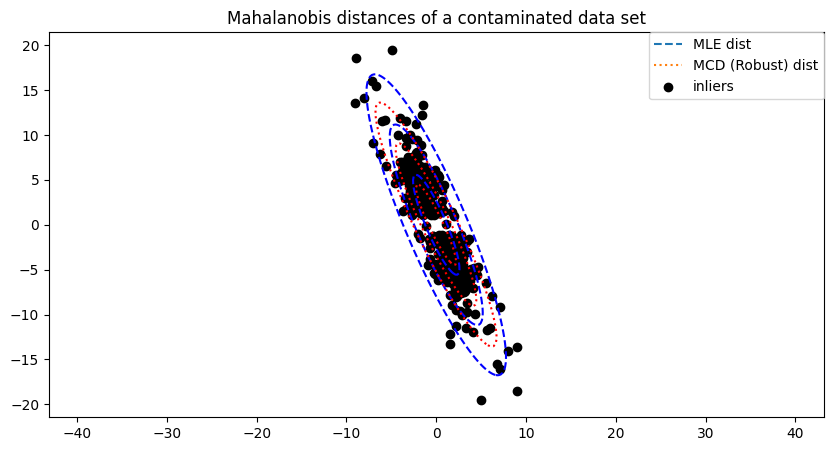

In [230]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(10, 5))
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color="black", label="inliers")
# Plot data set

# outlier_plot = ax.scatter(
#     X[:, 0][-n_outliers:], X[:, 1][-n_outliers:], color="red", label="outliers"
# )
ax.set_xlim(ax.get_xlim()[0], 10.0)
ax.set_title("Mahalanobis distances of a contaminated data set")

# Create meshgrid of feature 1 and feature 2 values
xx, yy = np.meshgrid(
    np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
    np.linspace(plt.ylim()[0], plt.ylim()[1], 100),
)
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)

mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)

print(np.sqrt(mahal_emp_cov))
emp_cov_contour = plt.contour(
    xx, yy, np.sqrt(mahal_emp_cov), linestyles="dashed",
    levels=np.arange(1, 4), colors='b'
)
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(
    xx, yy, np.sqrt(mahal_robust_cov), linestyles="dotted",
    levels=np.arange(1, 4), colors='red'
)

# Add legend
ax.legend(
    [
        mlines.Line2D([], [], color="tab:blue", linestyle="dashed"),
        mlines.Line2D([], [], color="tab:orange", linestyle="dotted"),
        inlier_plot,
        # outlier_plot,
    ],
    ["MLE dist", "MCD (Robust) dist", "inliers"],
    loc="upper right",
    borderaxespad=0,
)
ax.axis('equal')
plt.show()